In [27]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [22]:
conn = sqlite3.connect('db_crypto.db')
query = 'SELECT * FROM bars'
crypto_bars = pd.read_sql_query(query, conn)
crypto_bars.set_index('timestamp', inplace=True)
conn.close()
crypto_bars.head()

,id,symbol,close,high,low,trade_count,open,volume,vwap,added_on
timestamp,,,,,,,,,,
2023-01-01 00:00:00,1637030,BTC/USD,16526.71,16527.58,16522.40,32,16526.26,0.501588,16526.222459,2023-11-27 00:06:13
2023-01-01 00:01:00,1637031,BTC/USD,16522.53,16526.82,16522.53,15,16526.81,0.310298,16526.496182,2023-11-27 00:06:13
2023-01-01 00:02:00,1637032,BTC/USD,16519.60,16524.45,16518.27,37,16521.43,1.431526,16520.893111,2023-11-27 00:06:13
2023-01-01 00:03:00,1637033,BTC/USD,16517.78,16520.08,16513.80,28,16520.08,2.233005,16515.797387,2023-11-27 00:06:13
2023-01-01 00:04:00,1637034,BTC/USD,16514.59,16517.74,16510.37,54,16517.74,5.893288,16512.371553,2023-11-27 00:06:13


In [24]:
data_BTCUSD = crypto_bars[crypto_bars['symbol'] == 'BTC/USD'][['close']]

In [25]:
five_days = 5 * 24 * 60
data_BTCUSD['SMA5'] = data_BTCUSD['close'].rolling(five_days).mean()

twenty_days = 20 * 24 * 60
data_BTCUSD['SMA20'] = data_BTCUSD['close'].rolling(twenty_days).mean()

<Axes: title={'center': 'Cumulative Returns'}, xlabel='timestamp'>

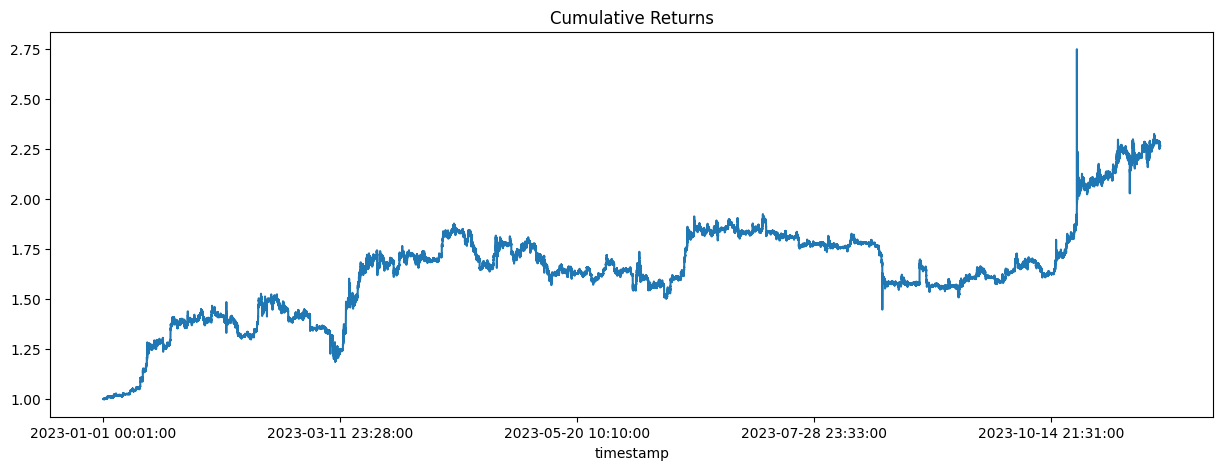

In [62]:
data_BTCUSD['close'].pct_change()\
    .dropna()\
    .apply(lambda x: x + 1)\
    .cumprod()\
    .plot(figsize=(15, 5), title='Cumulative Returns')

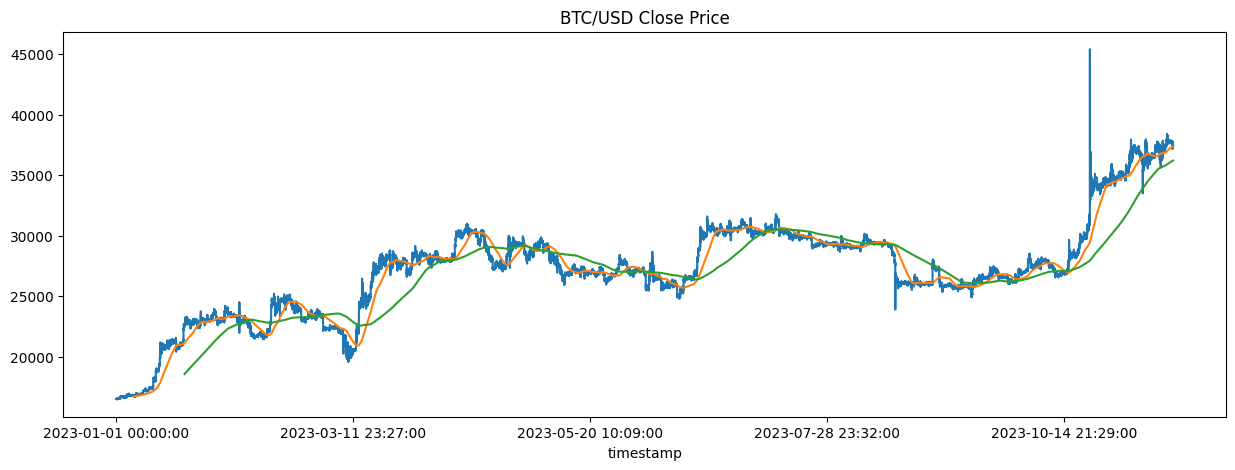

In [61]:
data_BTCUSD['close'].plot(figsize=(15, 5), title='BTC/USD Close Price')
data_BTCUSD['SMA5'].plot()
data_BTCUSD['SMA20'].plot()
plt.show()

In [28]:
data_BTCUSD["crossover_signal"] = np.where(data_BTCUSD['SMA5'] >= data_BTCUSD['SMA20'], 1, 0)
data_BTCUSD["prev_crossover_signal"] = data_BTCUSD["crossover_signal"].shift(1, fill_value=0)

data_BTCUSD["buy"] = (data_BTCUSD["crossover_signal"] == 1) & (data_BTCUSD["prev_crossover_signal"] == 0)
data_BTCUSD["buy"] = data_BTCUSD["buy"].replace({True: 1, False: 0})

data_BTCUSD["sell"] = (data_BTCUSD["crossover_signal"] == 0) & (data_BTCUSD["prev_crossover_signal"] == 1)
data_BTCUSD["sell"]  = data_BTCUSD["sell"].replace({True: 1, False: 0})

In [31]:
capital = 100000
risk_per_trade = 0.02

In [66]:
data_BTCUSD["buy_quantity"] = np.where(data_BTCUSD["buy"] == 1, capital * risk_per_trade / data_BTCUSD["close"], 0)
data_BTCUSD["buy_quantity"] = data_BTCUSD["buy_quantity"].replace({np.nan: 0})

data_BTCUSD["sell_quantity"] = np.where(data_BTCUSD["sell"] == 1, capital * risk_per_trade / data_BTCUSD["close"], 0)
data_BTCUSD["sell_quantity"] = data_BTCUSD["sell_quantity"].replace({np.nan: 0})

In [67]:
data_BTCUSD["quantity"] = data_BTCUSD["buy_quantity"] - data_BTCUSD["sell_quantity"]

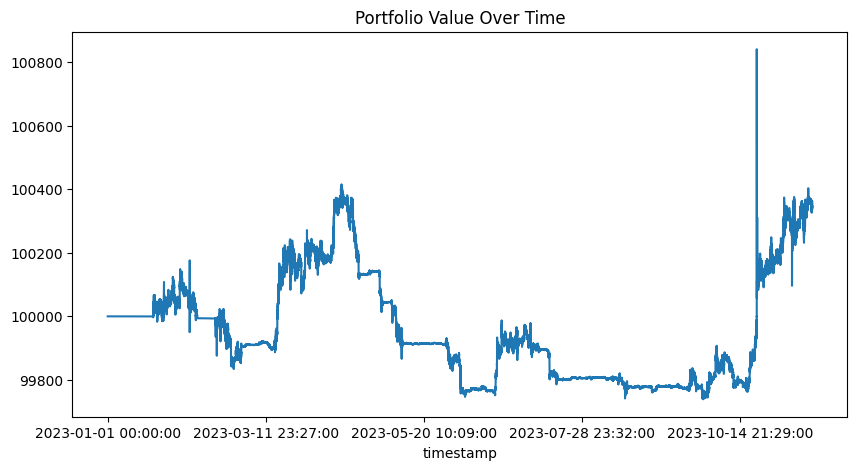

Total Return: 0.34%


In [68]:
initial_capital = capital
portfolio_value = initial_capital
cash = initial_capital
position = 0

data_BTCUSD['portfolio_value'] = 0.0
data_BTCUSD['position'] = 0.0

for index, row in data_BTCUSD.iterrows():
    # Buy BTC/USD
    if row['buy'] == 1:
        buy_quantity = row['buy_quantity']
        cash -= buy_quantity * row['close']
        position += buy_quantity

    # Sell BTC/USD
    elif row['sell'] == 1:
        sell_quantity = row['sell_quantity']
        cash += sell_quantity * row['close']
        position -= sell_quantity

    # Update portfolio value
    portfolio_value = cash + position * row['close']
    data_BTCUSD.at[index, 'portfolio_value'] = portfolio_value
    data_BTCUSD.at[index, 'position'] = position

# Plot portfolio value over time
data_BTCUSD['portfolio_value'].plot(figsize=(10, 5), title='Portfolio Value Over Time')
plt.show()

# Calculate and print total return
total_return = (portfolio_value - initial_capital) / initial_capital
print(f"Total Return: {total_return * 100:.2f}%")